In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # scaling transform
from sklearn.metrics import accuracy_score, zero_one_loss
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import re, string
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from scipy import sparse


# EXPLORATION

In [101]:
tr = pd.read_csv("./train.csv")
val_X = pd.read_csv("./test.csv")
val_Y = pd.read_csv("./test_labels.csv")



In [102]:
tr['comment_text'][0] # shows an example of a possible text in the training dataset

"Explanation\r\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [103]:
lens = tr.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(396.5939613087591, 594.3878690070298, 5000)

<Axes: >

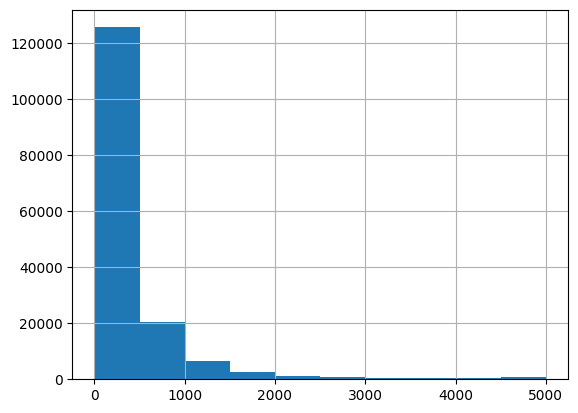

In [104]:
lens.hist()

In [105]:
x=tr.iloc[:,2:].sum() #grabs the sum of all the 'tags' and values that equal 1 for any of the toxicity classes
#marking comments without any tags as "clean"
x.index
rowsums=tr.iloc[:,2:].sum(axis=1) 
tr['noclass']=(rowsums==0) #labels the rows with all '0' for the toxicity as clean
#count number of clean entries
tr['noclass'].sum()
print("Total comments = ",len(tr))
print("Total comments with no classes = ",tr['noclass'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total comments with no classes =  143346
Total tags = 35098


total number of occurances for toxic: 15294
total number of occurances for severe_toxic: 1595
total number of occurances for obscene: 8449
total number of occurances for threat: 478
total number of occurances for insult: 7877
total number of occurances for identity_hate: 1405
total number of occurances for noclass: 143346


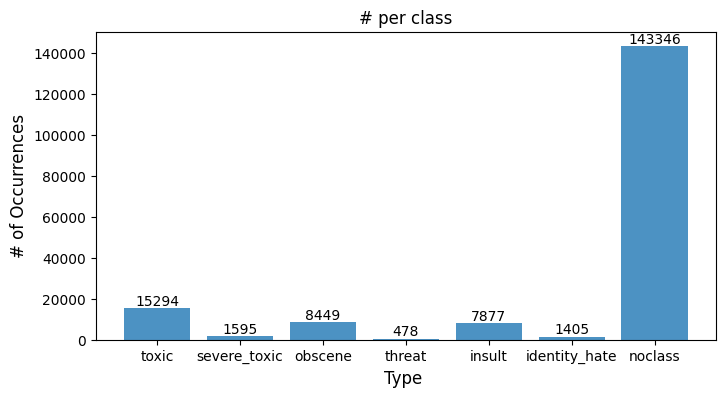

In [106]:
x=tr.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= plt.bar(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
l = []
i =0
for rect, label in zip(rects, labels):
    height = rect.get_height()
    print(f'total number of occurances for {x.index[i]}: {height}')
    l.append(height)
    i+= 1

plt.bar_label(ax, labels=l)

plt.show()

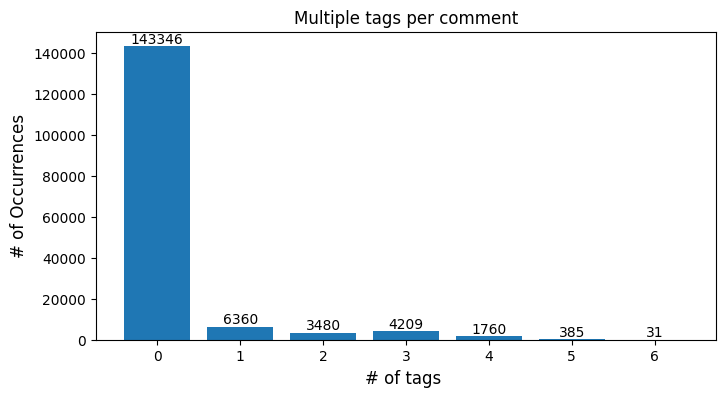

In [107]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = plt.bar(x.index, x.values)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
l = []
for rect, label in zip(rects, labels):
    height = rect.get_height()
    l.append(height)
    
plt.bar_label(ax, labels=l)

plt.show()

In [108]:
print("invalid rows:", len(val_Y[val_Y["toxic"] == -1]))
print("total rows:", len(val_Y))

invalid rows: 89186
total rows: 153164


In [109]:
feature_column = val_Y.iloc[:, 1]
val_X = val_X[feature_column != -1]
val_Y = val_Y[feature_column != -1]

In [110]:
#explain that we visualized our data and at first glance we saw that there is a lot of clean data (data representation)

In [111]:
#discuss the graph and explain how a comment can have  multiple tags and different types of toxicity 

In [112]:
#show the number of unique words over total words (illustrate the point that the bag of words will be sparse)

In [113]:


 def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"'s", " ", text)
    text = re.sub(r"'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'d", " would ", text)
    text = re.sub(r"'ll", " will ", text)
    text = re.sub(r"'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text.split()


# Count Vectorizer

In [114]:
vectorizer = CountVectorizer(tokenizer=clean_text, strip_accents='unicode', stop_words='english')
tr_term_document_matrix = vectorizer.fit_transform(tr["comment_text"])
val_term_document_matrix = vectorizer.transform(val_X["comment_text"])

In [115]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [116]:

train_predictions = np.zeros((len(tr), len(classes)))
val_predictions = np.zeros((len(val_X), len(classes)))
for i, c in enumerate(classes):
    model = LogisticRegression().fit(tr_term_document_matrix, tr[c])
    train_predictions[:, i] = model.predict(tr_term_document_matrix)
    val_predictions[:, i] = model.predict(val_term_document_matrix)
    print("training error for " + c + ":", zero_one_loss(tr[c], train_predictions[:, i]))
    print("validation error for " + c + ":", zero_one_loss(val_Y[c], val_predictions[:, i]))

training error for toxic: 0.025593622901404434
validation error for toxic: 0.07613554659414179
training error for severe_toxic: 0.007908705215860068
validation error for severe_toxic: 0.006924255212729324
training error for obscene: 0.017026903384700254
validation error for obscene: 0.04052955703523087
training error for threat: 0.0018424400423635579
validation error for threat: 0.0050642408327862265
training error for insult: 0.026508576119721017
validation error for insult: 0.042592766263403026
training error for identity_hate: 0.006993751997543374
validation error for identity_hate: 0.012488667979618007


# Tf-Idf Vectorizer

In [117]:
word_count_by_class = []

for target in classes:
    word_count = Counter()
    for _comment in tr[tr[target] == 1]["comment_text"]:
        for word in clean_text(_comment):
            if word not in ENGLISH_STOP_WORDS:
                word_count[word] += 1
    word_count_by_class.append(word_count)
    # print(word_count.most_common(8))



Text(0.5, 1.05, 'Top 10 words in each class by count')

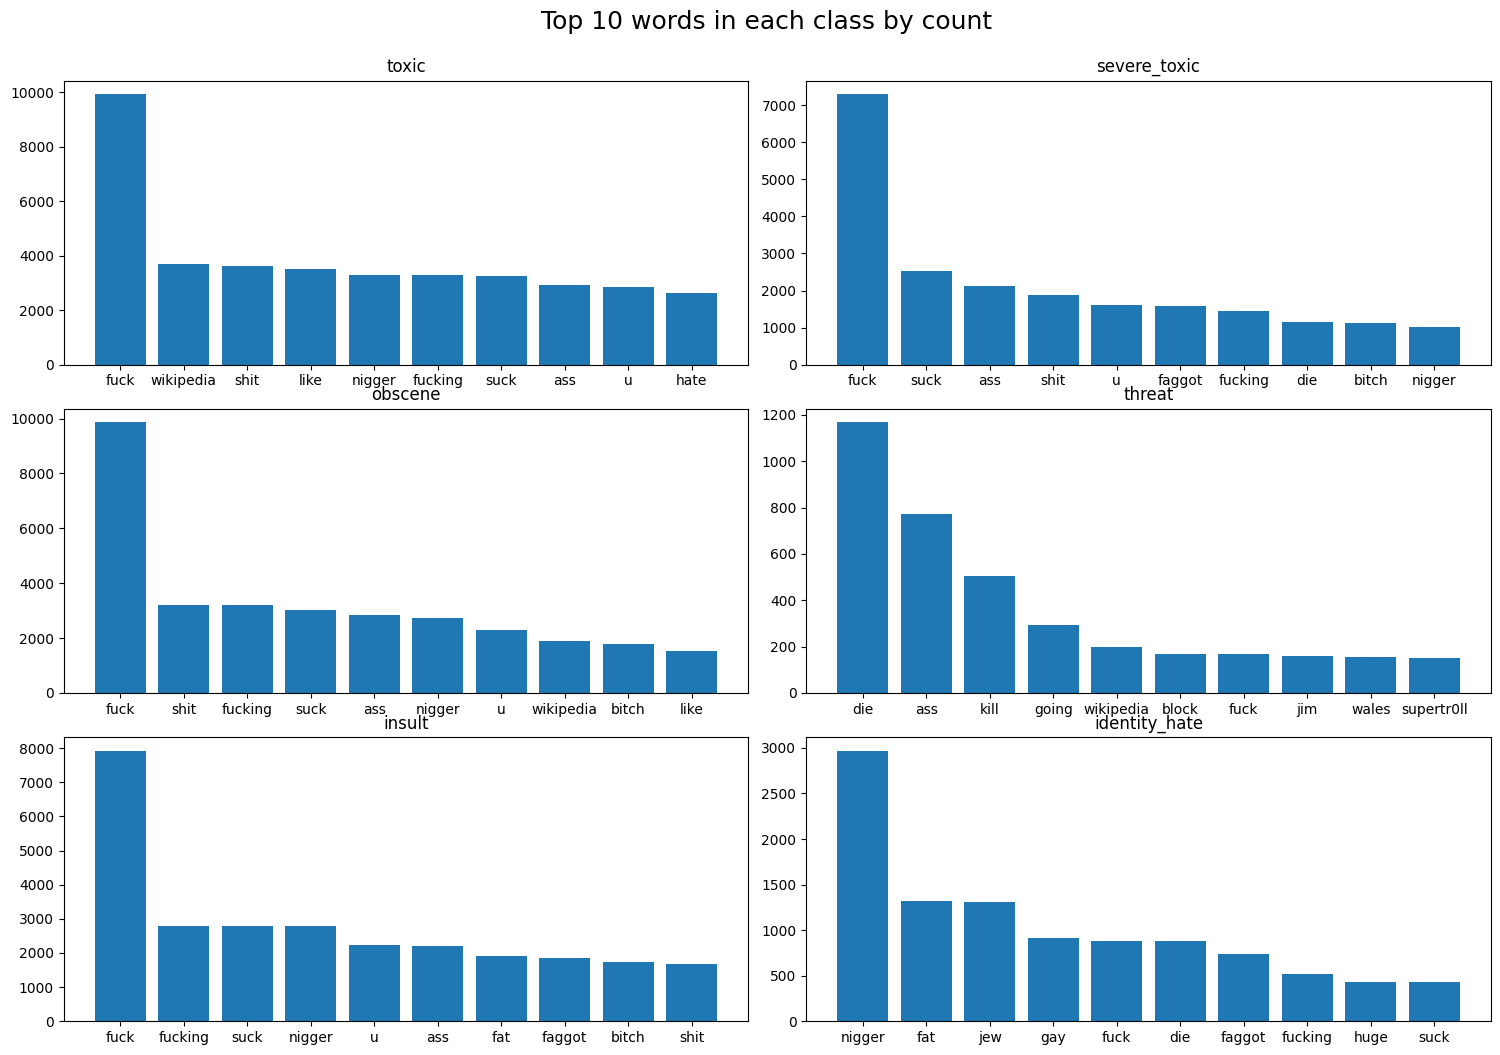

In [118]:
fig, ax = plt.subplots(3, 2, figsize = (15, 10))
fig.tight_layout()
pos = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
for i, target in enumerate(classes):
    top10 = word_count_by_class[i].most_common(10)
    r, c = pos[i]
    ax[r][c].bar([top[0] for top in top10], [top[1] for top in top10])
    ax[r][c].set_title(target)

fig.suptitle("Top 10 words in each class by count", y=1.05, fontsize=18)

In [119]:
# tr[tr["toxic"] == 1]["comment_text"]
tr.shape

(159571, 9)

In [120]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=clean_text, strip_accents='unicode', stop_words='english')
tr_term_tfidf_doc_matrix = tfidf_vectorizer.fit_transform(tr["comment_text"])
val_term_tfidf_doc_matrix = tfidf_vectorizer.transform(val_X["comment_text"])


In [121]:
target_info_all = tr.iloc[:,2:]

In [122]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    for target in classes:
        ids = target_info_all.index[tr[target]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        dfs.append(feats_df)
    return dfs

In [123]:
tfidf_top_n_per_class=top_feats_by_class(tr_term_tfidf_doc_matrix, np.array(tfidf_vectorizer.get_feature_names_out()))
# tfidf_top_n_per_class[0]

Text(0.5, 1.05, 'Top 10 words in each class by tf-idf')

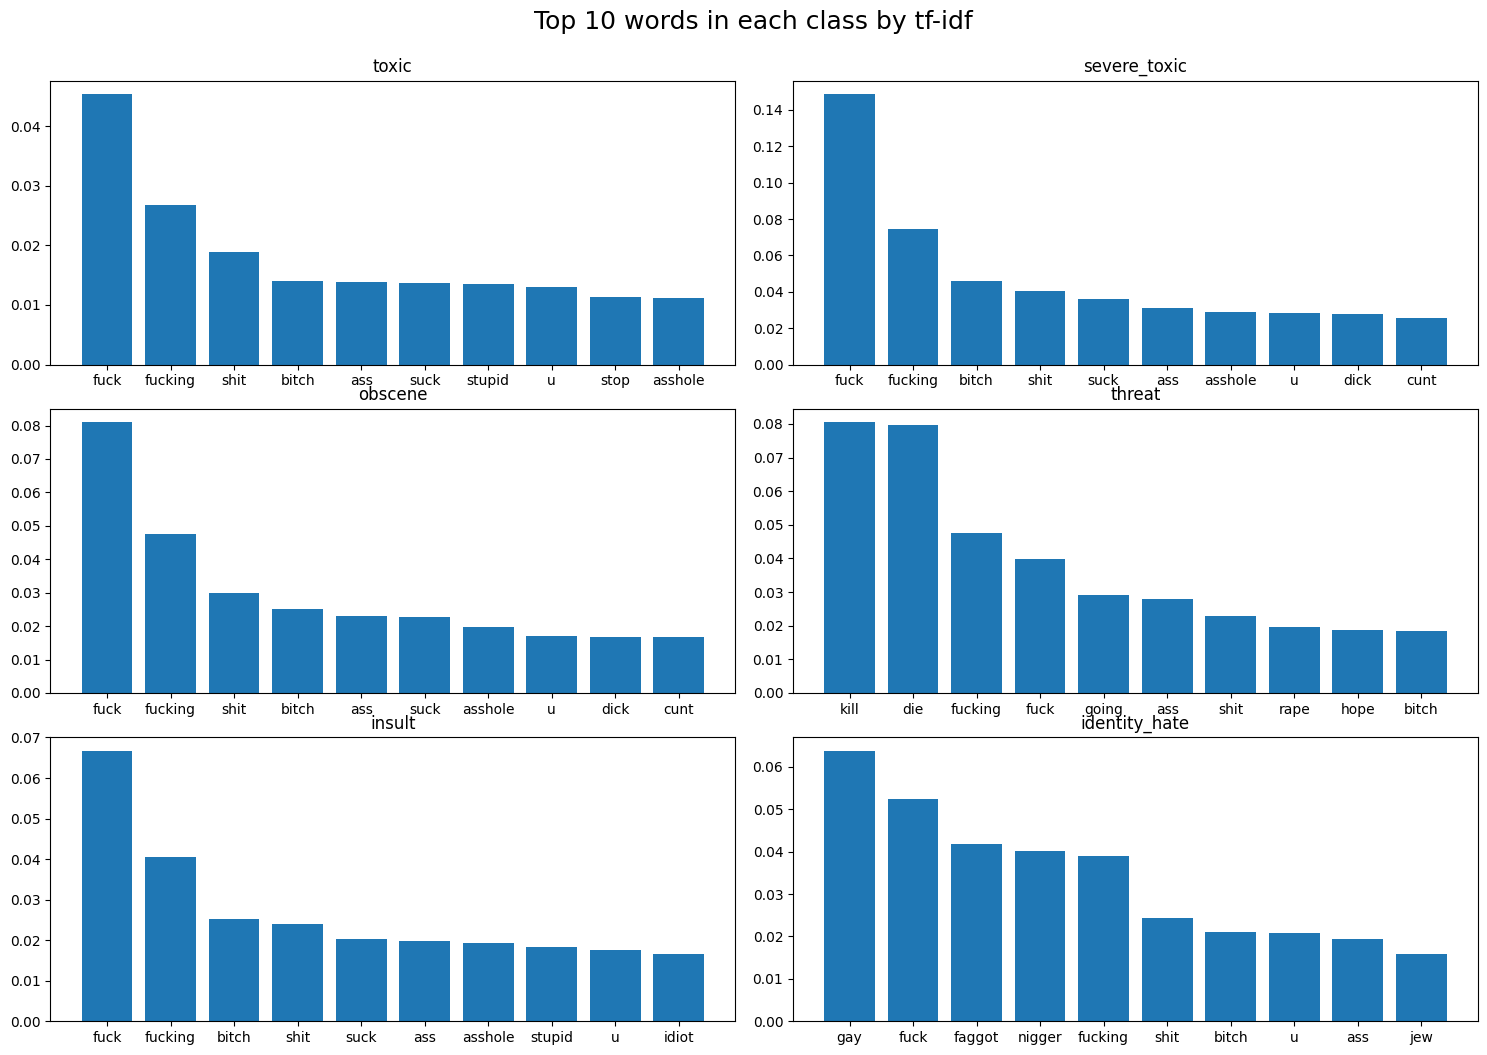

In [124]:
# tfidf_top_n_per_class[0][:10]

fig, ax = plt.subplots(3, 2, figsize = (15, 10))
fig.tight_layout()

for i, target in enumerate(classes):
    top10 = tfidf_top_n_per_class[i][:10]
    r, c = pos[i]
    ax[r][c].bar(top10["feature"], top10["tfidf"])
    ax[r][c].set_title(target)

fig.suptitle("Top 10 words in each class by tf-idf", y=1.05, fontsize=18)

In [125]:
tr_pred_tfidf = np.zeros((len(tr), len(classes)))
val_pred_tfidf = np.zeros((len(val_X), len(classes)))
for i, c in enumerate(classes):
    model = LogisticRegression().fit(tr_term_tfidf_doc_matrix, tr[c])
    tr_pred_tfidf[:, i] = model.predict(tr_term_tfidf_doc_matrix)
    val_pred_tfidf[:, i] = model.predict(val_term_tfidf_doc_matrix)
    print("training error for " + c + ":", zero_one_loss(tr[c], tr_pred_tfidf[:, i]))
    print("validation error for " + c + ":", zero_one_loss(val_Y[c], val_pred_tfidf[:, i]))

training error for toxic: 0.03891057898991668
validation error for toxic: 0.06388133420863418
training error for severe_toxic: 0.008798591222715868
validation error for severe_toxic: 0.006705429991559653
training error for obscene: 0.0202355064516736
validation error for obscene: 0.034293038231892226
training error for threat: 0.00278872727500612
validation error for threat: 0.0033136390634280755
training error for insult: 0.027028720757531155
validation error for insult: 0.036965832004751675
training error for identity_hate: 0.007676833509848269
validation error for identity_hate: 0.009675200850292276


In [126]:
# what if we predict all zeroes
pred_all_zeroes = val_pred_tfidf = np.zeros((len(val_X), len(classes)))
for i, c in enumerate(classes):
    print("validation error for " + c + ":", zero_one_loss(val_Y[c],pred_all_zeroes[:, i]))


validation error for toxic: 0.09518897120885306
validation error for severe_toxic: 0.005736346869236297
validation error for obscene: 0.0576917065241177
validation error for threat: 0.003298008690487353
validation error for insult: 0.053565288067773276
validation error for identity_hate: 0.011128825533777253


# NBSVM

In [127]:
# https://github.com/sanshibayuan/NBSVM/blob/master/nbsvm.py
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):#NB
            p = x[y==y_i].sum()
            return (p+1) / ((y==y_i).sum()+1) 
        
        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y))) 
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)#SVM/LR
        return self

In [128]:
count_vec_bigram = CountVectorizer(tokenizer=clean_text, strip_accents='unicode', stop_words='english', ngram_range=(1, 2))
tr_doc_matrix_bigram = count_vec_bigram.fit_transform(tr["comment_text"])
val_doc_matrix_bigram = count_vec_bigram.transform(val_X["comment_text"])

In [129]:
tr_pred_nbsvm_count = np.zeros((len(tr), len(classes)))
val_pred_nbsvm_count = np.zeros((len(val_X), len(classes)))

for i, c in enumerate(classes):
    model = NbSvmClassifier().fit(tr_doc_matrix_bigram, tr[c])
    tr_pred_nbsvm_count[:, i] = model.predict(tr_doc_matrix_bigram)
    val_pred_nbsvm_count[:, i] = model.predict(val_doc_matrix_bigram)
    print("training error for " + c + ":", zero_one_loss(tr[c], tr_pred_nbsvm_count[:, i]))
    print("validation error for " + c + ":", zero_one_loss(val_Y[c], val_pred_nbsvm_count[:, i]))
    

training error for toxic: 0.04052114732626855
validation error for toxic: 0.0712588702366439
training error for severe_toxic: 0.0076580331012526814
validation error for severe_toxic: 0.006549126262152649
training error for obscene: 0.0223662194258355
validation error for obscene: 0.040701491137578594
training error for threat: 0.0027949940778713156
validation error for threat: 0.004595329644565327
training error for insult: 0.02707885518045261
validation error for insult: 0.041389227546969276
training error for identity_hate: 0.008598053531030048
validation error for identity_hate: 0.011363281127887759


In [130]:
tfidf_vectorizer_bigram = TfidfVectorizer(tokenizer=clean_text, strip_accents='unicode', stop_words='english', ngram_range=(1, 2))
tr_tfidf_doc_matrix_bigram = tfidf_vectorizer_bigram.fit_transform(tr["comment_text"])
val_tfidf_doc_matrix_bigram = tfidf_vectorizer_bigram.transform(val_X["comment_text"])

In [131]:
tr_pred_nbsvm_tfidf_bigram = np.zeros((len(tr), len(classes)))
val_pred_nbsvm_tfidf_bigram = np.zeros((len(val_X), len(classes)))

for i, c in enumerate(classes):
    model = NbSvmClassifier(C=5).fit(tr_tfidf_doc_matrix_bigram, tr[c])
    tr_pred_nbsvm_tfidf_bigram[:, i] = model.predict(tr_tfidf_doc_matrix_bigram)
    val_pred_nbsvm_tfidf_bigram[:, i] = model.predict(val_tfidf_doc_matrix_bigram)
    print("training error for " + c + ":", zero_one_loss(tr[c], tr_pred_nbsvm_tfidf_bigram[:, i]))
    print("validation error for " + c + ":", zero_one_loss(val_Y[c], val_pred_nbsvm_tfidf_bigram[:, i]))

training error for toxic: 0.0648426092460409
validation error for toxic: 0.06206821094751325
training error for severe_toxic: 0.009086864154514318
validation error for severe_toxic: 0.007565100503298061
training error for obscene: 0.03223643393849762
validation error for obscene: 0.03585607552596204
training error for threat: 0.0030017985724223317
validation error for threat: 0.003329269436368798
training error for insult: 0.03624718777221425
validation error for insult: 0.039451061302322676
training error for identity_hate: 0.008717122785468545
validation error for identity_hate: 0.011081934414955086


In [132]:
# tfidf_vectorizer_bigram2 = TfidfVectorizer(tokenizer=clean_text, strip_accents='unicode', ngram_range=(1, 2))
# tr_tfidf_doc_matrix_bigram2 = tfidf_vectorizer_bigram.fit_transform(tr["comment_text"])
# val_tfidf_doc_matrix_bigram2 = tfidf_vectorizer_bigram.transform(val_X["comment_text"])

In [133]:
# with our without stopwords the results are the same

# tr_pred_nbsvm_tfidf_bigram2 = np.zeros((len(tr), len(classes)))
# val_pred_nbsvm_tfidf_bigram2 = np.zeros((len(val_X), len(classes)))

# for i, c in enumerate(classes):
#     model = NbSvmClassifier(C=5).fit(tr_tfidf_doc_matrix_bigram2, tr[c])
#     tr_pred_nbsvm_tfidf_bigram2[:, i] = model.predict(tr_tfidf_doc_matrix_bigram2)
#     val_pred_nbsvm_tfidf_bigram2[:, i] = model.predict(val_tfidf_doc_matrix_bigram2)
#     print("training error for " + c + ":", zero_one_loss(tr[c], tr_pred_nbsvm_tfidf_bigram2[:, i]))
#     print("validation error for " + c + ":", zero_one_loss(val_Y[c], val_pred_nbsvm_tfidf_bigram2[:, i]))